# Libraries and Data Cleaning

In [116]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

products = pd.read_csv('data/Products.csv') # product id, name, price
customers = pd.read_csv('data/customers.csv') # customer id, name, address
orders = pd.read_csv('data/orders.csv') # order date, customer id, product id, quantity, rating
orders['Date'] = pd.to_datetime(orders['Date'])

In [117]:
orders_with_price = pd.merge(left = orders, right = products, on = 'ProductId', how = "left")
orders_with_price.rename(columns={"Price" : "Unit Price"}, inplace=True)
orders_with_price

,Date,CustomerId,ProductId,Quantity,Rating,ProductName,Unit Price
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150
1,2021-01-01,C847,P35,4,5.0,Book,20
2,2021-01-01,C399,P8,5,3.0,Women's Watch,150
3,2021-01-01,C1231,P53,6,3.0,Travel Pillow,20
4,2021-01-01,C369,P44,8,4.0,Deodorant,5
...,...,...,...,...,...,...,...
74995,2022-01-31,C601,P71,3,2.0,Umbrella,12
74996,2022-01-31,C1297,P68,2,5.0,Snow Boots,80
74997,2022-01-31,C760,P70,7,1.0,Snow Pants,80
74998,2022-01-31,C1361,P9,8,4.0,Men's Watch,200


# RFM Analysis

### Create RFMT df

In [118]:
orders_with_price.describe()

,Quantity,Rating,Unit Price
count,75000.000000,67870.000000,75000.000000
mean,5.008187,3.001459,100.939480
std,2.584899,1.415853,189.108321
min,1.000000,1.000000,2.000000
25%,3.000000,2.000000,15.000000
50%,5.000000,3.000000,50.000000
75%,7.000000,4.000000,100.000000
max,9.000000,5.000000,1200.000000


In [119]:
orders_with_price.isnull().sum()

Date              0
CustomerId        0
ProductId         0
Quantity          0
Rating         7130
ProductName       0
Unit Price        0
dtype: int64

In [120]:
# Drop NA
orders_with_price.dropna(inplace=True)

In [121]:
# Recency: date of analysis - purchase date of customer

max_date = orders_with_price['Date'].max()
analysis_date = pd.to_datetime('today')
recency = (analysis_date - orders_with_price.groupby(['CustomerId'])['Date'].max()).dt.days

# frequency: total number of purchases by a customer
frequency = orders_with_price.groupby(['CustomerId'])['CustomerId'].count()

# monetary: total value of customers purchase
orders_with_price['Revenue'] = orders_with_price['Quantity'] * orders_with_price['Unit Price']
cust_value = orders_with_price.groupby(['CustomerId'])['Revenue'].sum()

# tenure: days since first purchase
tenure = (analysis_date - orders_with_price.groupby(['CustomerId'])['Date'].min()).dt.days

In [122]:
rfm = pd.DataFrame() 
rfm["Recency"] = recency
rfm["Frequency"] = frequency
rfm["Monetary"] = cust_value
rfm["Tenure"] = tenure
rfm.head()

,Recency,Frequency,Monetary,Tenure
CustomerId,,,,
C0,399,54,18916,787
C1,408,38,16520,788
C10,424,52,23490,769
C100,399,44,13897,781
C1000,408,58,24293,788


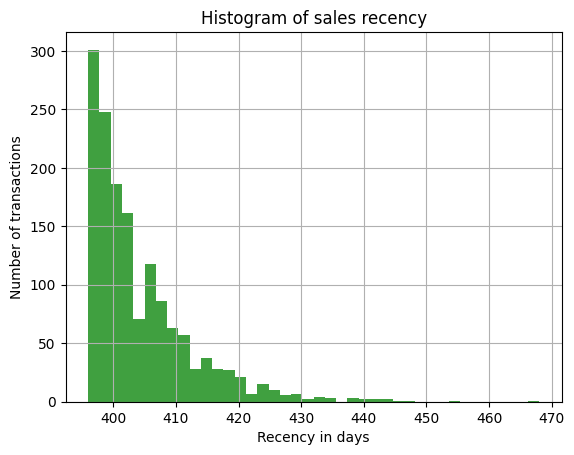

In [123]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 40, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)

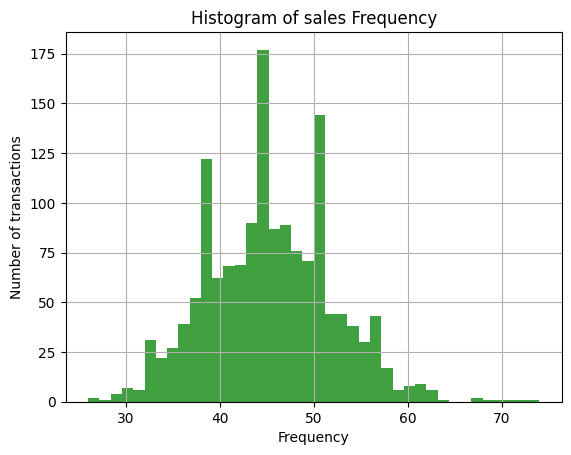

In [124]:
# Frequency plot
x = rfm.Frequency
mu = np.mean(rfm.Frequency)
sigma = math.sqrt(np.var(rfm.Frequency))
n, bins, patches = plt.hist(x, 40, facecolor='green', alpha=0.75)
plt.xlabel('Frequency')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales Frequency')
plt.grid(True)

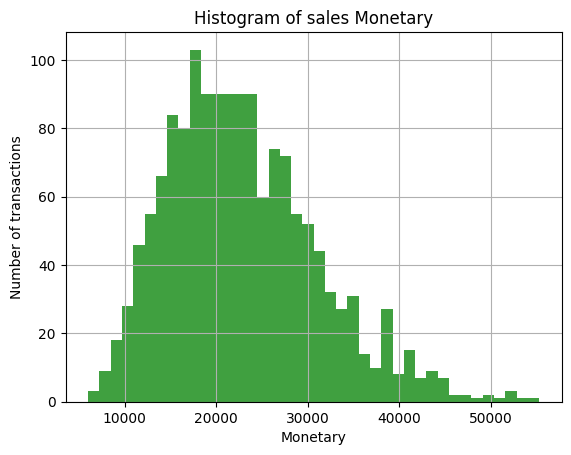

In [125]:
# Monetary plot
x = rfm.Monetary
mu = np.mean(rfm.Monetary)
sigma = math.sqrt(np.var(rfm.Monetary))
n, bins, patches = plt.hist(x, 40, facecolor='green', alpha=0.75)
plt.xlabel('Monetary')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales Monetary')
plt.grid(True)

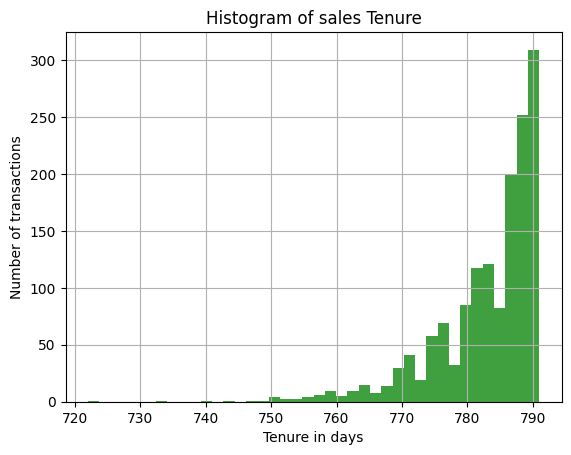

In [126]:
# Tenure plot
x = rfm.Tenure
mu = np.mean(rfm.Tenure)
sigma = math.sqrt(np.var(rfm.Tenure))
n, bins, patches = plt.hist(x, 40, facecolor='green', alpha=0.75)
plt.xlabel('Tenure in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales Tenure')
plt.grid(True)

In [127]:
# scale all RFMT values in the range 1-5

min_max_scaler = MinMaxScaler((1,5))
scaled = min_max_scaler.fit_transform(rfm[["Recency","Frequency","Monetary","Tenure"]])
rfm = pd.DataFrame(scaled, columns=rfm.columns)
rfm.head()

,Recency,Frequency,Monetary,Tenure
0,1.166667,3.333333,2.046959,4.768116
1,1.666667,2.000000,1.852214,4.826087
2,2.555556,3.166667,2.418731,3.724638
3,1.166667,2.500000,1.639018,4.420290
4,1.666667,3.666667,2.483998,4.826087


### Cluster Analysis

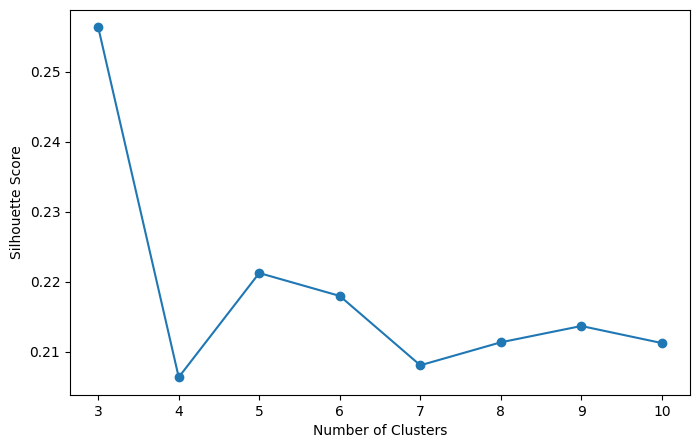

In [128]:
from sklearn.cluster import DBSCAN

X = rfm.values 
n_cluster = range(3, 11, 1)
sil_score = []


kmedoids_tuned = KMeans(n_clusters=4)
y_fit_kmedians = kmedoids_tuned.fit_predict(X)


for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=123)
    y_fit= model.fit_predict(X)
    # model.fit(X)
    sil_score.append(silhouette_score(X = X, labels = y_fit)
)
    
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, sil_score, marker="o")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
plt.show()

As seen above, the best number of segments seem to be 4, which is reasonable to split customers into

### Cluster and Assign Clusters

In [129]:
n_cluster = 4

model = KMeans(n_clusters=n_cluster, random_state=123)
y = model.fit_predict(rfm[["Recency","Frequency","Monetary","Tenure"]])

rfm["Cluster"] = y
rfm.head() 

,Recency,Frequency,Monetary,Tenure,Cluster
0,1.166667,3.333333,2.046959,4.768116,2
1,1.666667,2.000000,1.852214,4.826087,0
2,2.555556,3.166667,2.418731,3.724638,3
3,1.166667,2.500000,1.639018,4.420290,0
4,1.666667,3.666667,2.483998,4.826087,2


In [130]:
# Recency: smaller is better
# Frequency: larger is better
# Monetary: larger is better
# Tenure: larger is better


rfm["Score"] = 0.6*(1/rfm['Recency']) + 0.2*rfm['Frequency'] + 0.2*rfm['Monetary'] # 1/recency: larger is better
rfm.groupby(['Cluster']).mean().sort_values(by=['Score'])

,Recency,Frequency,Monetary,Tenure,Score
Cluster,,,,,
3,2.362434,2.332451,2.266577,4.491143,1.183294
0,1.310051,2.108748,1.883998,4.410548,1.273364
2,1.298654,2.917693,2.237067,4.662292,1.509781
1,1.360867,3.017107,3.294462,4.580433,1.723779


In [131]:
label = {3:'Poor', 0:'OK', 2:'Good', 1:'Excellent'}
rfm["Cluster"].replace(label,inplace=True)
rfm.head(5)

,Recency,Frequency,Monetary,Tenure,Cluster,Score
0,1.166667,3.333333,2.046959,4.768116,Good,1.590344
1,1.666667,2.000000,1.852214,4.826087,OK,1.130443
2,2.555556,3.166667,2.418731,3.724638,Poor,1.351862
3,1.166667,2.500000,1.639018,4.420290,OK,1.342089
4,1.666667,3.666667,2.483998,4.826087,Good,1.590133


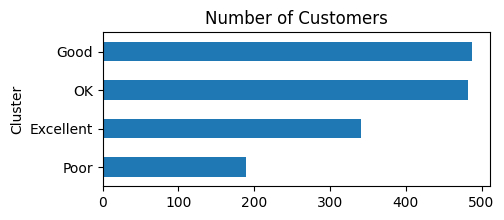

In [132]:
rfm.groupby('Cluster').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

As seen above, most customers are classified as good and ok customers in terms of their recency, frequency, and monetary value.

# Market Basket Analysis

## Create Itemsets

In [133]:
orders_with_price

,Date,CustomerId,ProductId,Quantity,Rating,ProductName,Unit Price,Revenue
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150,750
1,2021-01-01,C847,P35,4,5.0,Book,20,80
2,2021-01-01,C399,P8,5,3.0,Women's Watch,150,750
3,2021-01-01,C1231,P53,6,3.0,Travel Pillow,20,120
4,2021-01-01,C369,P44,8,4.0,Deodorant,5,40
...,...,...,...,...,...,...,...,...
74995,2022-01-31,C601,P71,3,2.0,Umbrella,12,36
74996,2022-01-31,C1297,P68,2,5.0,Snow Boots,80,160
74997,2022-01-31,C760,P70,7,1.0,Snow Pants,80,560
74998,2022-01-31,C1361,P9,8,4.0,Men's Watch,200,1600


In [134]:
from itertools import chain, combinations
import collections
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

# Analyzing transactions
# Create unique transaction_id by combining date and customer_id
orders_with_price['TransactionId'] = orders_with_price['CustomerId'] + orders_with_price['Date'].astype(str)

basket = orders_with_price.groupby(['TransactionId', 'ProductId'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('TransactionId')
basket.head(5)

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
TransactionId,,,,,,,,,,,,,,,,,,,,,
C02021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C02021-01-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C02021-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C02021-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
C02021-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
def encode_units(x):
    if x >= 1:
        return True
    else:
        return False

#convert each value into 0 or 1
basket_sets = basket.applymap(encode_units)
basket_sets.head(5)

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
TransactionId,,,,,,,,,,,,,,,,,,,,,
C02021-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C02021-01-20,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C02021-01-22,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C02021-01-23,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
C02021-03-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [136]:
#How many items in each transaction
items_per_trans = basket_sets.sum(numeric_only = True, axis=1).reset_index(name ='ItemCount')

In [137]:
items_per_trans

,TransactionId,ItemCount
0,C02021-01-05,1
1,C02021-01-20,1
2,C02021-01-22,1
3,C02021-01-23,1
4,C02021-03-06,1
...,...,...
64231,C9992021-11-16,1
64232,C9992021-12-05,1
64233,C9992021-12-16,1
64234,C9992021-12-19,1


In [138]:
freq_items = fpgrowth(basket_sets, min_support = 1/len(basket_sets), use_colnames = True)
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
freq_items

,support,itemsets,length
0,0.008842,(P30),1
1,0.009200,(P82),1
2,0.008313,(P34),1
3,0.009294,(P93),1
4,0.008796,(P80),1
...,...,...,...
3117,0.000016,"(P73, P95)",2
3118,0.000016,"(P57, P95)",2
3119,0.000016,"(P105, P95)",2
3120,0.000016,"(P6, P95)",2


## Association Rules

In [139]:
rules = association_rules(freq_items, metric='lift', min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(P102, P52)",(P30),0.000016,0.008842,0.000016,1.000000,113.091549,0.000015,inf
1,"(P102, P30)",(P52),0.000016,0.009574,0.000016,1.000000,104.448780,0.000015,inf
2,"(P52, P30)",(P102),0.000016,0.009496,0.000016,1.000000,105.304918,0.000015,inf
3,(P102),"(P52, P30)",0.009496,0.000016,0.000016,0.001639,105.304918,0.000015,1.001626
4,(P52),"(P102, P30)",0.009574,0.000016,0.000016,0.001626,104.448780,0.000015,1.001613
...,...,...,...,...,...,...,...,...,...
747,"(P21, P24)",(P53),0.000016,0.008842,0.000016,1.000000,113.091549,0.000015,inf
748,"(P53, P24)",(P21),0.000016,0.008733,0.000016,1.000000,114.502674,0.000015,inf
749,(P21),"(P53, P24)",0.008733,0.000016,0.000016,0.001783,114.502674,0.000015,1.001770
750,(P53),"(P21, P24)",0.008842,0.000016,0.000016,0.001761,113.091549,0.000015,1.001748


# Recommendation Engine

## Use a hybrid between item-based CF and user-based CF

In [140]:
from sklearn.model_selection import train_test_split

X = orders_with_price.drop(labels=['Rating'], axis = 1)
y = orders_with_price['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)
ratings_train = pd.concat([X_train, y_train], axis = 1)
ratings_test = pd.concat([X_test, y_test], axis = 1)

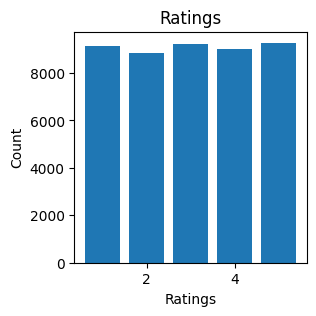

In [141]:
temp_df = ratings_train.groupby(['Rating']).size()
plt.figure(figsize=(3, 3))
plt.bar(x=temp_df.index, height=temp_df.values, label="Ratings")
plt.title('Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [142]:
temp_df

Rating
1.0    9122
2.0    8833
3.0    9237
4.0    9000
5.0    9280
dtype: int64

## Ratings Matrix

In [143]:
# Utility Matrix
# Note that there are no 0 ratings, so it is ok to use 0 as no rating
utility = pd.pivot_table(data = ratings_train, index = 'CustomerId', columns = 'ProductId', values = 'Rating')
utility = utility.fillna(0)
utility.head()

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
CustomerId,,,,,,,,,,,,,,,,,,,,,
C0,0.0,0.0,1.0,3.5,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
C1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0
C10,0.0,5.0,5.0,1.0,4.5,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
C100,0.0,0.0,4.5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1000,5.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0


## User-user

In [144]:
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error

k = 5
metric = 'cosine'

def findksimilarusers(CustomerId, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.loc[CustomerId, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar users for User {1}:\n'.format(k,CustomerId))
    for i in range(0, len(indices.flatten())):
        if ratings.index[indices.flatten()[i]] == CustomerId:
            continue
        else:
            print ('{0}: User {1} with similarity of {2}'.format(i, ratings.index[indices.flatten()[i]], similarities.flatten()[i]))
            
    return similarities,indices

similarities,indices = findksimilarusers('C0',utility, metric='cosine')

5 most similar users for User C0:

1: User C771, with similarity of 0.4874091827833972
2: User C883, with similarity of 0.46214137797419574
3: User C246, with similarity of 0.4518753916633389
4: User C361, with similarity of 0.4463083949434917
5: User C718, with similarity of 0.4402097445460409


## Item-item

In [153]:
def findksimilaritems(ProductId, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    distances, indices = model_knn.kneighbors(ratings.loc[ProductId,:].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar items for item {1}:\n'.format(k,ProductId))
    for i in range(0, len(indices.flatten())):
        if ratings.index[indices.flatten()[i]] == ProductId:
            continue

        else:
            print ('{0}: Item {1} with similarity of {2}'.format(i,ratings.index[indices.flatten()[i]], similarities.flatten()[i]))


    return similarities,indices

similarities,indices = findksimilaritems('P1',utility, metric='cosine')

5 most similar items for item P1:

1: Item P6 :, with similarity of 0.23708522158064993
2: Item P59 :, with similarity of 0.23198474251368084
3: Item P15 :, with similarity of 0.224380201350308
4: Item P68 :, with similarity of 0.22325961295268815
5: Item P28 :, with similarity of 0.2228849917415895


# Strategy

## RFM Analysis

Using RFM analysis, we can look at which existing customers are our "best customers" and that we should seek to retain. We should also focus on the other segments to improve their recency, frequency, and monetary value. We can also pick out the largest segment that is either poor, ok, or good to focus on their pain points. We can develop a strategy to solve their problems and hopefully increase their RFM and turn them into a higher-tier customer

## Market Basket Analysis + CF Recommender

Using market basket analysis, we can look at association rules between items. That is, what items are tend to be bought together? Along with the CF recommender that computes item-item and user-user similarity according to ratings of items, we can fine tune a recommendation system that would allow items that are frequently bought together as well as similar items be recommended to a user who would likely buy them.